In [1]:
%load_ext autoreload
%autoreload 2

<p style="font-size:32px; font-weight: bolder; text-align: center">Equivariant ML models</p>
<p style="font-size:16px; text-align: center">A tutorial introduction</p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

_Equivariance_ indicates the property of a function for which the inputs and outputs are subject to the action of the same symmetries, and which commutes with the application of the symmetries, that is: $f(\hat{S}A) = \hat{S} f(A)$. _Invariance_ can be seen as a special case, in which  $f(\hat{S}A) = f(A)$.

This notebook provides a brief introduction to the concept of equivariance in the context of atomic-scale machine-learning models, focusing in particular on the case of 3D rotations and inversion - in technical terms the $O(3)$ group symmetries - and their combination with translations - the three-dimensional Euclidean group $E(3)$. 

# The tools of the trade

We will use a number of packages, including both general-purpose ones and some that are designed specifically to the construction and manipulation of equivariant ML models. You should be able to fetch most of these from PIP, while others might require a custom installation.

Besides some time-tested classics...

In [2]:
import numpy as np
import matplotlib.pyplot as plt

... we will use [ASE](https://wiki.fysik.dtu.dk/ase/) to load and manipulate atomic structures 

In [3]:
import ase.io

... [chemiscope](https://chemiscope.org) to visualize them, [equistore](https://github.com/lab-cosmo/equistore) to hold equivariant quantities and [rascaline](https://github.com/Luthaf/rascaline) to compute atom-centered density correlations (ACDCs) - the main family of equivariant descriptors we will use.

In [4]:
import equistore
import chemiscope
from rascaline import SphericalExpansion

## Water dataset

We use as a demonstrative dataset a simple dataset that contains a water molecule, stretched and bent in different ways. For each configuration, the dataset holds energy, forces and dipole moments, computed using the high-accuracy [Partridge-Schwenke fits](10.1063/1.473987). 

In [5]:
frames = ase.io.read("data/chemrev_nuprime-theta-grid_computed.xyz", ":")

In [6]:
cs = chemiscope.show(frames, 
        settings={
            'map' : { 'x':{'property' : "HOH"},  'y':{'property' : "OH1"}, 'color' : {'property' : 'energy'} },
            'structure': [{'axes': 'xyz','keepOrientation': True}]
        })
display(cs)

/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[ 0.439333 -0.486919  0.      ]' of type '<class 'numpy.ndarray'>' for the 'force' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[-0.00853353  0.49287236  0.        ]' of type '<class 'numpy.ndarray'>' for the 'dipole' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "settings": {"map": {"x": {"property": "HOH"}, "y":…

Processes the properties of the structures (as stored in the `.extxyz` file) as `TensorBlock` objects. We will see later how these can be used. 

In [7]:
energy_values = []
force_values = []
dipole_values = []
for f in frames:
    energy_values.append(f.info['energy'])
    dipole_values.append(f.info['dipole'])
    force_values.append(f.arrays['force'])

In [8]:
energies = equistore.TensorBlock(values=np.asarray(energy_values).reshape(-1,1,1), 
                                 samples=equistore.labels.Labels(names = ["structure"], values=np.arange(len(frames), dtype=np.int32).reshape(-1,1) ),
                                 components=[equistore.labels.Labels.single()],
                                 properties=equistore.labels.Labels.single(),
                                )

energies.add_gradient("positions", data=-np.array(force_values).reshape(-1,3,1,1),
                      samples=equistore.labels.Labels(names=["sample", "atom"], 
                                                      values=np.asarray(np.vstack([ [[i,0],[i,1],[i,2]] for i in range(len(frames))]),dtype=np.int32) ),
                      components=[equistore.labels.Labels(names=["gradient_direction"], values=np.asarray([[0,1,2]], dtype=np.int32).T),
                                  equistore.labels.Labels.single()
                                 ]
                     )

In [9]:
dipoles = equistore.TensorBlock(values=np.asarray(dipole_values).reshape(-1,3,1), 
                                 samples=equistore.labels.Labels(names = ["structure"], values=np.arange(len(frames), dtype=np.int32).reshape(-1,1) ),
                                 components=[equistore.labels.Labels(names=["direction"], values=np.asarray([[0,1,2]], dtype=np.int32).T) ],
                                 properties=equistore.labels.Labels.single(),
                                )

# Rotations and vectors

Let's now start looking into how a vector such as the dipole moment rotates. The key concept is that a vectorial property such as the atomic positions or the dipole moment transform, under the action of a rotation operation $\hat{R}$ in a way consistent with the application of a rotation matrix $\mathbf{R}$, i.e. if a structure $A$ has atomic positions $\mathbf{r}_i$ and dipole moment $\mathbf{y}_i$ (each of these being a 3-vector corresponding to the Cartesian coordinates $(x,y,z)$) then the rotated structure $\hat{R}A$ has atomic coordinates $\mathbf{R}\mathbf{r}_i$ and dipole moment $\mathbf{R}\mathbf{y}$. 


<img src="figures/rotations.png" width="400"/>

A rotation can be defined in terms of [Euler angles](https://en.wikipedia.org/wiki/Euler_angles), a set of three angles $(\alpha, \beta, \gamma)$ that define the orientation of a rigid body relative to a reference frame.  This is a problem that is made quite tricky by the existence of dozen of alternative conventions. For those in the know, we use the $ZYZ$ intrinsic rotations definition, which is also the one commonly used to define quantities in angular momentum theory. We use a wrapper from some utilities that returns the rotation matrix in the "correct" format, and use it to generate a set of water molecules in which the position of the atoms and the molecular dipoles have been rotated appropriately. 

In [10]:
from utils.rotations import rotation_matrix, xyz_to_spherical, spherical_to_xyz, wigner_d_real
from utils.clebsh_gordan import ClebschGordanReal

In [40]:
rotated_structures = []
rotated_wdipole = []
selected_frame = frames[47]
selected_dipole = dipoles.values[94,:,0]
# adds two fake atoms to show the magnitude and direction of the dipole moment
dipole_mol = ase.Atoms("FH", positions=[[0,2,0],selected_dipole+[0,2,0]])
for alpha in np.linspace(0, 2*np.pi, 8):
    for beta in np.linspace(0, np.pi, 4):
        for gamma in np.linspace(0, 2*np.pi, 8):
            rot_frame = selected_frame.copy() 
            rot_frame.info['alpha'] = alpha
            rot_frame.info['beta'] = beta
            rot_frame.info['gamma'] = gamma
            # rotates the frame
            R = rotation_matrix(alpha, beta, gamma)
            rot_frame.positions = rot_frame.positions@R.T
            rot_frame.cell = rot_frame.cell@R.T
            rot_frame.info['dipole'] = rot_frame.info['dipole']@R.T
            rotated_structures.append(rot_frame)
            
            # just for visualization, frames with dipole visualized as HF
            rot_frame = selected_frame.copy() + dipole_mol
            rot_frame.positions = rot_frame.positions@R.T
            rot_frame.cell = rot_frame.cell@R.T
            rot_frame.info.update(dict(alpha=alpha, beta=beta, gamma=gamma))
            rotated_wdipole.append(rot_frame)

In [41]:
cs = chemiscope.show(rotated_wdipole, 
        settings={
            'map' : {
                'x' : {'property' : 'alpha'},
                'y' : {'property' : 'beta'},
                'z' : {'property' : 'gamma'},
                'color' : {'property' : 'energy'} },
            'structure': [{'axes': 'xyz','keepOrientation': True}]
        })
display(cs)

/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[ 0.0797022  -0.00155446  0.        ]' of type '<class 'numpy.ndarray'>' for the 'force' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[0.0091859  0.42833807 0.        ]' of type '<class 'numpy.ndarray'>' for the 'dipole' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "settings": {"map": {"x": {"property": "alpha"}, "y…

# Rotations and arbitrary tensors

Vectorial quantities such as are just one of the possible types of equivariant properties associated with a molecular structure. We consider as an example the tensor

$$
\mathbf{Y} = \mathbf{y}\mathbf{y}^T + |\mathbf{y}|^2 \mathbf{1},  
$$

built starting from the dipole moment $\mathbf{y}$. 

In [13]:
def y_to_Y(y):
    return y.reshape(-1,1)@y.reshape(1,-1) + (y@y)*np.eye(3)

In [14]:
for rot_frame in rotated_structures:
    rot_frame.info['Y'] = y_to_Y(rot_frame.info['dipole'])

This quantity transforms under rotation as $\mathbf{Y}(\hat{R}A) = \mathbf{R}\mathbf{Y}(A)\mathbf{R}^T$. 
While this is a perfectly fine way of expressing the transformation, it is more complicated than necessary: all the $9$ components of $\mathbf{Y}$ are formally mixed in the process, and even though it is linear in $\mathbf{Y}$, to explicitly cast it as such requires combining the two multiplications by $\mathbf{R}$ into the multiplication by a large, $9\times 9$ matrix.

In [15]:
# picks one of the rotated structures
base = rotated_structures[0]
selected = rotated_structures[11]
base_Y = base.info['Y']
selected_Y = selected.info['Y']
# builds the rotation matrix
R = rotation_matrix(selected.info['alpha'], selected.info['beta'], selected.info['gamma'])

In [16]:
print(base_Y)
# rotated Y matches the Y of the rotated structure
print(R@base_Y@R.T)
print(selected_Y)

[[0.18364226 0.00393467 0.        ]
 [0.00393467 0.36703138 0.        ]
 [0.         0.         0.18355788]]
[[ 0.19297902  0.03707146 -0.0163179 ]
 [ 0.03707146  0.3294312  -0.06420965]
 [-0.0163179  -0.06420965  0.21182131]]
[[ 0.19297902  0.03707146 -0.0163179 ]
 [ 0.03707146  0.3294312  -0.06420965]
 [-0.0163179  -0.06420965  0.21182131]]


In [17]:
# builds the 9x9 rotation matrix - can you follow the index juggling?
flat_idx = np.array([(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)], dtype=int)
RR = R[flat_idx[:,0]][:,flat_idx[:,0]]*R[flat_idx[:,1]][:,flat_idx[:,1]]

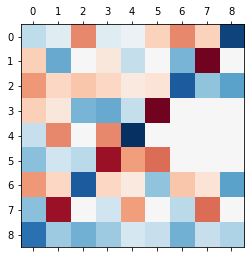

In [18]:
# the 9x9 matrix is almost entirely full
plt.matshow(RR, cmap=plt.cm.RdBu, vmin=-max(np.abs(RR.flatten())), vmax=max(np.abs(RR.flatten())))

In [19]:
# this rotates the tensor with a single multiplication
(RR@(base_Y[flat_idx[:,0],flat_idx[:,1]])).reshape(3,3)

array([[ 0.19297902,  0.03707146, -0.0163179 ],
       [ 0.03707146,  0.3294312 , -0.06420965],
       [-0.0163179 , -0.06420965,  0.21182131]])

This brings us to the concept of _irreducible_ representations of the rotation group. In very hand-wavy terms, we look for ways to simplify the transformation by recombining entries in $\mathbf{Y}$ in such a way that they are less mixed up when acted upon by a rotation $\hat{R}$. 
That this might be possible can be seen by noticing that the _trace_ of $\mathbf{Y}$, $Y_{xx}+Y_{yy}+ Y_{zz}$ is left unchanged by the rotation - it is _invariant_.

In [20]:
print(np.trace(base_Y), np.trace(selected_Y))

0.7342315280913774 0.7342315280913776


It turns out that products of Cartesian coordinates can be rearranged into blocks that transform under rotation as _spherical harmonics_, $Y^m_l$. The theory is not entirely trivial, and gets even messier if (as we do here) one wants to express everything in terms of _real_ spherical harmonics. 
The manipulations here are somewhat opaque (and rely heavily on utility functions) but allow to follow the construction of the _spherical tensor_ form of $\mathbf{Y}$. 

In [21]:
# we need Clebsch-Gordan coefficients to transform the Cartesian tensor into an irreducible form
cg = ClebschGordanReal(l_max=2)
cg.couple(xyz_to_spherical(base_Y))

{(1, 1): {0: array([-0.42390877]),
  1: array([0., 0., 0.]),
  2: array([ 0.00556446,  0.        , -0.07493719,  0.        , -0.12967569])}}

The output indicates that the tensor was built as the product of two vector-like ($l=1$) spherical Harmonics, and it has been decomposed into a scalar ($l=0$), pseudo-vector ($l=1$, zero because the tensor is symmetric), and higher-order ($l=2$) term. Each block contains $2m+1$ components. We can therefore stack these in a a single array with 9 components, that could (in principle) be written as a unitary transformation of the initial Cartesian form.

In [22]:
def to_coupled(cartesian):
    coupled = cg.couple(xyz_to_spherical(cartesian))
    return np.hstack( [coupled[(1,1)][l] for l in [0,1,2]] )
base_coupled_Y = to_coupled(base_Y)
selected_coupled_Y = to_coupled(selected_Y)
# note that elements [1:4] are zero: this is a consequence of the symmetry of Y
print(base_coupled_Y)
print(selected_coupled_Y)

[-0.42390877  0.          0.          0.          0.00556446  0.
 -0.07493719  0.         -0.12967569]
[-0.42390877  0.          0.          0.          0.05242696 -0.09080616
 -0.04032171 -0.02307699 -0.09648626]


Compare the $9\timex 9$ matrix above with that associated with rotating the tensor in this new basis. Each of the irreducible blocks transform separately, so the rotation matrix is block-diagonal. _Any_ Cartesian tensor can be expressed in terms of a collection of $Y^m_l$-like irreducible blocks.

In [23]:
# the rotation matrix for the irreducible form can be built from a collection
# of (real-valued) Wigner D matrices
coupled_RR = np.zeros((9,9))
coupled_RR[0,0] = wigner_d_real(0, selected.info['alpha'], selected.info['beta'], selected.info['gamma'])
coupled_RR[1:4,1:4] = wigner_d_real(1, selected.info['alpha'], selected.info['beta'], selected.info['gamma'])
coupled_RR[4:9,4:9] = wigner_d_real(2, selected.info['alpha'], selected.info['beta'], selected.info['gamma'])

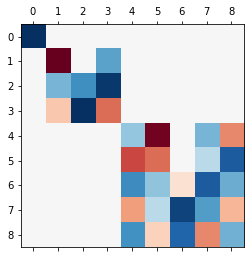

In [24]:
# the 9x9 matrix is block diagonal
plt.matshow(coupled_RR, cmap=plt.cm.RdBu, vmin=-max(np.abs(RR.flatten())), vmax=max(np.abs(RR.flatten())))

In [25]:
# this block-diagonal matrix performs a rotation in the irreducible spherical basis
print(base_coupled_Y)
print(coupled_RR@base_coupled_Y)
print(selected_coupled_Y)

[-0.42390877  0.          0.          0.          0.00556446  0.
 -0.07493719  0.         -0.12967569]
[-0.42390877  0.          0.          0.          0.05242696 -0.09080616
 -0.04032171 -0.02307699 -0.09648626]
[-0.42390877  0.          0.          0.          0.05242696 -0.09080616
 -0.04032171 -0.02307699 -0.09648626]


The transformation can be reverted to bring the tensor back to its Cartesian form

In [26]:
coupled = {(1,1): {0:selected_coupled_Y[:1], 1:selected_coupled_Y[1:4], 2: selected_coupled_Y[4:9]}}
spherical_to_xyz(cg.decouple(coupled))

array([[ 0.19297902,  0.03707146, -0.0163179 ],
       [ 0.03707146,  0.3294312 , -0.06420965],
       [-0.0163179 , -0.06420965,  0.21182131]])

# Density expansion coefficients

We now move on to discuss how to describe an atomic environment using expansion coefficients of the atomic density. In short, the idea is to start describing a molecule $A$ in terms of localized functions (e.g. Gaussians) centered on each atom $i$, "labelled" by their chemical nature $a$

$$
\langle a \mathbf{x} | A; \rho\rangle = \sum_{i \in A} \delta_{a a_i} \langle \mathbf{x} | \mathbf{r}_i \rangle.
$$

We use  the notation $\langle \mathbf{x} | \mathbf{r}_i \rangle = g(\mathbf{x}-\mathbf{r}_i)$ to emphasize how the full structure is built as a sum of terms that describe individual atoms. In general terms, in analogy with the Dirac notation used to describe a quantum state, the notation $\langle q | A\rangle$ to indicate a descriptor $| A\rangle$ for an entity $A$, discretized in a basis that is enumerated by the index $q$. 
See Section 3.1 of [this review](https://doi.org/10.1021/acs.chemrev.1c00021) for a gentler introduction. 

This density is then symmetrized with respect to translations (reflecting the fact that atomic properties are invariant to rigid translations of a molecule) which leads to expressing the structure descriptors as a sum of descriptors of _atom centered environments_ $A_i$,


$$
\langle a \mathbf{x} | \rho_i\rangle = \sum_{j \in A_i} \delta_{a a_j} \langle \mathbf{x} | \mathbf{r}_{ji} \rangle.
$$

where the Gaussians are evaluated at the interatomic distance vectors $\mathbf{r}_{ji}=\mathbf{r}_j-\mathbf{r}_i$.

To manipulate this atom-centered density, it is more convenient to express it on a discrete basis. Again, in analogy with what is done routinely in quantum chemistry for the electron wafefunction (or density) we use a basis of radial functions $R_{nl}(x) \equiv \langle x||nl\rangle$ and spherical harmonics $Y^m_{l}(\hat{\mathbf{x}}) \equiv \langle \hat{\mathbf{x}}|lm\rangle$

$$
\langle a nlm | \rho_i\rangle = \int \mathrm{d}\mathbf{x} 
 \langle nl| x\rangle  \langle lm| \hat{\mathbf{x}} \rangle
\langle a \mathbf{x} | \rho_i\rangle  
$$

## Computing descriptors with _rascaline_ and _equistore_

We use `rascaline` to compute the density expansion coefficients for these water molecule structures. 
The coefficients are returned as a `equistore.TensorMap` object, that reflects some of the considerations discussed above on the structure of atom-centered density features

In [27]:
hypers = {
    "cutoff": 3.5,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0,
    "gradients": True,
}

calculator = SphericalExpansion(**hypers)

descriptor = calculator.compute(frames)

A `TensorMap` object works as a container that holds blocks of data. The pattern is reminiscent of a `dict`, but with some more structure and metadata: each block is associated with a _key_, which consists in a tuple of ints. The set of keys is a `equistore.Labels` object, that also keeps track of the _names_ that describe each index in the key. 

The expansion keys hold the `spherical_harmonics_l index`, and two indices corresponding to the atomic number of the central atom `species_center` and of the neighbors `species_neighbor`. 

In [28]:
descriptor.keys

Labels([(0, 1, 1), (1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1),
        (6, 1, 1), (0, 1, 8), (1, 1, 8), (2, 1, 8), (3, 1, 8), (4, 1, 8),
        (5, 1, 8), (6, 1, 8), (0, 8, 1), (1, 8, 1), (2, 8, 1), (3, 8, 1),
        (4, 8, 1), (5, 8, 1), (6, 8, 1), (0, 8, 8), (1, 8, 8), (2, 8, 8),
        (3, 8, 8), (4, 8, 8), (5, 8, 8), (6, 8, 8)],
       dtype=[('spherical_harmonics_l', '<i4'), ('species_center', '<i4'), ('species_neighbor', '<i4')])

Each block is associated to a `equistore.TensorBlock` object. Each block is associated with a dense tensor with a `samples` direction (enumerating the items that are described) a `properties` direction (enumerating actual properties, or descriptors) and zero or more `components` - typical examples would be the Cartesian coordinates of a vector, or the $m$ index in spherical harmonics. Each is associated with a `Labels` object that stores metadata that describe the entries.

In [29]:
# this is l=2, central atom is O and neighbor is H
block = descriptor.block(spherical_harmonics_l=2,species_center=8,species_neighbor=1)

In [30]:
block.samples

Labels([(  0, 0), (  1, 0), (  2, 0), (  3, 0), (  4, 0), (  5, 0),
        (  6, 0), (  7, 0), (  8, 0), (  9, 0), ( 10, 0), ( 11, 0),
        ( 12, 0), ( 13, 0), ( 14, 0), ( 15, 0), ( 16, 0), ( 17, 0),
        ( 18, 0), ( 19, 0), ( 20, 0), ( 21, 0), ( 22, 0), ( 23, 0),
        ( 24, 0), ( 25, 0), ( 26, 0), ( 27, 0), ( 28, 0), ( 29, 0),
        ( 30, 0), ( 31, 0), ( 32, 0), ( 33, 0), ( 34, 0), ( 35, 0),
        ( 36, 0), ( 37, 0), ( 38, 0), ( 39, 0), ( 40, 0), ( 41, 0),
        ( 42, 0), ( 43, 0), ( 44, 0), ( 45, 0), ( 46, 0), ( 47, 0),
        ( 48, 0), ( 49, 0), ( 50, 0), ( 51, 0), ( 52, 0), ( 53, 0),
        ( 54, 0), ( 55, 0), ( 56, 0), ( 57, 0), ( 58, 0), ( 59, 0),
        ( 60, 0), ( 61, 0), ( 62, 0), ( 63, 0), ( 64, 0), ( 65, 0),
        ( 66, 0), ( 67, 0), ( 68, 0), ( 69, 0), ( 70, 0), ( 71, 0),
        ( 72, 0), ( 73, 0), ( 74, 0), ( 75, 0), ( 76, 0), ( 77, 0),
        ( 78, 0), ( 79, 0), ( 80, 0), ( 81, 0), ( 82, 0), ( 83, 0),
        ( 84, 0), ( 85, 0), ( 86, 0), ( 87, 0), 

In [31]:
block.properties

Labels([(0,), (1,), (2,), (3,), (4,), (5,)], dtype=[('n', '<i4')])

In [32]:
block.components

[Labels([(-2,), (-1,), ( 0,), ( 1,), ( 2,)],
        dtype=[('spherical_harmonics_m', '<i4')])]

Depending on the type of system or application, some indices might be stored more conveniently as samples, properties, components, or as sparse keys. _equistore_ provides utility functions to reorder the data for more convenient manipulation. For instance, in this case all atoms have the same type of neighbors, and so it does not make sense to use sparse storage for the neighbor element index. We can move the index from keys to properties:

In [33]:
descriptor.keys_to_properties('species_neighbor')

In [34]:
descriptor.keys

Labels([(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (0, 8),
        (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8)],
       dtype=[('spherical_harmonics_l', '<i4'), ('species_center', '<i4')])

In [35]:
descriptor.block(0).properties

Labels([(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (8, 0), (8, 1),
        (8, 2), (8, 3), (8, 4), (8, 5)],
       dtype=[('species_neighbor', '<i4'), ('n', '<i4')])

## Equivariance of the descriptors

Let's now see how the density coefficients actually behave as equivariant descriptors. This is kind of obvious given that we build them by expanding the density on a basis of spherical harmonics! Here we compute descriptors for two of the rotated structures, and see how the same result can be achieved by applying the rotation to the base molecule using a Wigner-D matrix.

In [69]:
base_descriptor = calculator.compute([base])
selected_descriptor = calculator.compute([selected])

In [70]:
base_descriptor.keys_to_properties('species_neighbor')
selected_descriptor.keys_to_properties('species_neighbor')

In [71]:
base_block = base_descriptor.block(spherical_harmonics_l=2, species_center=8)
selected_block = selected_descriptor.block(spherical_harmonics_l=2, species_center=8)

In [72]:
selected_block.values

array([[[-2.78057184e-03, -2.09470427e-03,  3.72169284e-03,
         -4.93995246e-04,  4.80375380e-04, -1.16941504e-04,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.81609170e-03,  3.62813422e-03, -6.44616108e-03,
          8.55624865e-04, -8.32034566e-04,  2.02548626e-04,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.98464930e-04,  6.80836715e-03,  1.09929448e-02,
         -7.01969928e-04,  9.60896746e-04, -2.31761838e-04,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.81659623e-02, -5.90483486e-02, -3.36247476e-02,
         -7.98590096e-05, -1.59202710e-03,  3.74619254e-04,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.27056385e-02, -5.6390722

In [50]:
wd = wigner_d_real(2, selected.info['alpha'], selected.info['beta'], selected.info['gamma'])

In [73]:
wd@base_block.values[0]

array([[-2.78057184e-03, -2.09470427e-03,  3.72169284e-03,
        -4.93995246e-04,  4.80375380e-04, -1.16941504e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.81609170e-03,  3.62813422e-03, -6.44616108e-03,
         8.55624865e-04, -8.32034566e-04,  2.02548626e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.98464930e-04,  6.80836715e-03,  1.09929448e-02,
        -7.01969928e-04,  9.60896746e-04, -2.31761838e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.81659623e-02, -5.90483486e-02, -3.36247476e-02,
        -7.98590096e-05, -1.59202710e-03,  3.74619254e-04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.27056385e-02, -5.63907221e-02, -1.9786175

In light of this, we can see density coefficients as _symmetry adapted_ descriptors. To emphasize their equivariant behavior, and that they reflect the distribution of neighbors by summing over them one of a time, we indicate the coefficients as 

$$
\langle an|\overline{\rho_i^{\otimes 1}; \lambda \mu }\rangle \equiv
\langle an\lambda \mu|\rho_i\rangle
$$

# Atom-centered density correlations

The density expansion coefficients can be regarded as the simplest possible form of an equivariant descriptor built based on the neighbor density. 